In [1]:
import ffmpeg

def extract_frame_info(video_path):
    try:
        # Probe the video to get detailed information
        probe = ffmpeg.probe(video_path)

        # Extract video stream information
        video_stream = next((stream for stream in probe['streams'] if stream['codec_type'] == 'video'), None)

        if video_stream is None:
            print('No video stream found in the file.')
        else:
            width = video_stream['width']
            height = video_stream['height']
            codec = video_stream['codec_name']
            frame_rate = eval(video_stream['r_frame_rate'])
            duration = float(video_stream['duration'])

            print(f'Video Width: {width}')
            print(f'Video Height: {height}')
            print(f'Codec: {codec}')
            print(f'Frame Rate: {frame_rate}')
            print(f'Duration: {duration} seconds')

    except ffmpeg.Error as e:
        print(f'Error: {e.stderr.decode()}')

if __name__ == "__main__":
    video_path =r'C:\Users\hp\Downloads\video (2).mp4'
    extract_frame_info(video_path)

Video Width: 640
Video Height: 360
Codec: h264
Frame Rate: 29.97002997002997
Duration: 10.477133 seconds


I-Frames: 3 (0.96%)
P-Frames: 87 (27.71%)
B-Frames: 224 (71.34%)


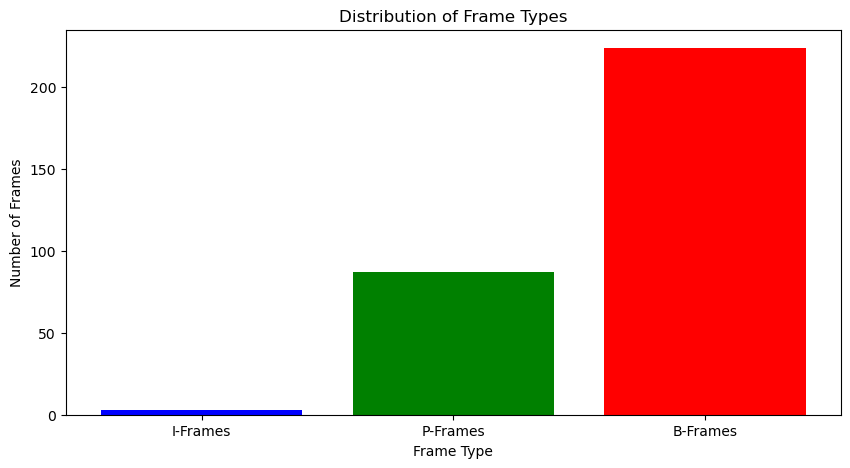

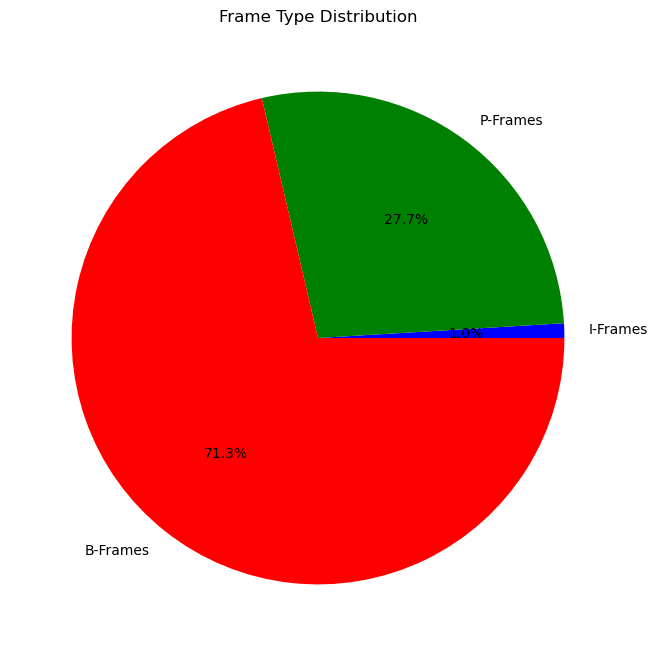

In [2]:
import matplotlib.pyplot as plt

def get_frame_counts(video_path):
    # Run ffprobe to get video stream information
    probe = ffmpeg.probe(video_path,select_streams='v', show_frames=None, show_entries='frame=pict_type')
    frames = probe['frames']

    # Initialize counts for each frame type
    counts = {'I': 0, 'P': 0, 'B': 0}
    for frame in frames:
        frame_type = frame.get('pict_type', 'Unknown')
        if frame_type in counts:
            counts[frame_type] += 1

    total = sum(counts.values())
    percentages = {key: (value / total) * 100 for key, value in counts.items()}

    # Output frame type counts and percentages
    print(f"I-Frames: {counts['I']} ({percentages['I']:.2f}%)")
    print(f"P-Frames: {counts['P']} ({percentages['P']:.2f}%)")
    print(f"B-Frames: {counts['B']} ({percentages['B']:.2f}%)")

    return counts, percentages

def visualize_frame_distribution(frame_counts, frame_percentages):
    labels = ['I-Frames', 'P-Frames', 'B-Frames']
    counts = [frame_counts['I'], frame_counts['P'], frame_counts['B']]

    # Bar Chart for frame type counts
    plt.figure(figsize=(10, 5))
    plt.bar(labels, counts, color=['blue', 'green', 'red'])
    plt.xlabel('Frame Type')
    plt.ylabel('Number of Frames')
    plt.title('Distribution of Frame Types')
    plt.show()

    # Pie Chart for frame type percentages
    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=['blue', 'green', 'red'])
    plt.title('Frame Type Distribution')
    plt.show()

# Provide the path to your video file
video_path = r'C:\Users\hp\Downloads\video (2).mp4'

# Obtain the frame counts and percentages
frame_counts, frame_percentages = get_frame_counts(video_path)

# Create visualizations for the frame distribution
visualize_frame_distribution(frame_counts, frame_percentages)

In [3]:
import os
from PIL import Image

# Function to extract specific frame types (I, P, B) and save them as images
def extract_frames_by_type(video_path, output_folder, frame_type):
    os.makedirs(output_folder, exist_ok=True)
    try:
        (
            ffmpeg
            .input(video_path)
            .output(f'{output_folder}/frame_%04d.png', vf=f'select=eq(pict_type\\,{frame_type})', vsync='vfr')
            .run()
        )
        print(f"{frame_type} frames extracted and saved to {output_folder}")
    except Exception as e:
        print(f"Error extracting {frame_type} frames: {e}")
        
# Function to display frames using PIL (Pillow)
def display_frames(folder_path):
    image_files = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if img.endswith('.png')]
    for image_file in image_files:
        img = Image.open(image_file)
        img.show()

video_path = r'C:\Users\hp\Downloads\video (2).mp4'

# Output directories for I, P, and B frames
output_folders = {
    'I': r'C:\Users\hp\Downloads\I_frames',
    'P': r'C:\Users\hp\Downloads\P_frames',
    'B': r'C:\Users\hp\Downloads\B_frames'
}

# Extract and display I, P, and B frames
for frame_type, folder in output_folders.items():
    extract_frames_by_type(video_path, folder, frame_type)
    display_frames(folder)

I frames extracted and saved to C:\Users\hp\Downloads\I_frames
P frames extracted and saved to C:\Users\hp\Downloads\P_frames
B frames extracted and saved to C:\Users\hp\Downloads\B_frames


In [7]:
import os
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim

# Define paths to the frame folders
i_frames_folder = r'C:\Users\hp\Downloads\I_frames'
p_frames_folder = r'C:\Users\hp\Downloads\P_frames'
b_frames_folder = r'C:\Users\hp\Downloads\B_frames'

# Function to calculate SSIM for frames in a given folder
def calculate_ssim(folder):
    ssim_values = []
    frame_files = sorted(os.listdir(folder))
    
    for i in range(len(frame_files) - 1):
        frame1_path = os.path.join(folder, frame_files[i])
        frame2_path = os.path.join(folder, frame_files[i + 1])
        
        frame1 = cv2.imread(frame1_path, cv2.IMREAD_GRAYSCALE)
        frame2 = cv2.imread(frame2_path, cv2.IMREAD_GRAYSCALE)
        
        score, _ = ssim(frame1, frame2, full=True)
        ssim_values.append(score)
    
    return ssim_values

# Calculate SSIM for I, P, and B frames
ssim_i_frames = calculate_ssim(i_frames_folder)
ssim_p_frames = calculate_ssim(p_frames_folder)
ssim_b_frames = calculate_ssim(b_frames_folder)

# Print average SSIM values for comparison
print(f'SSIM for I frames: {np.mean(ssim_i_frames)}')
print(f'SSIM for P frames: {np.mean(ssim_p_frames)}')
print(f'SSIM for B frames: {np.mean(ssim_b_frames)}')


SSIM for I frames: 0.48144984707651073
SSIM for P frames: 0.9574715868230104
SSIM for B frames: 0.9799702848543558


In [8]:
def calculate_file_size(file_path):
    return os.path.getsize(file_path)

# Function to calculate the average size of frames in a folder
def calculate_average_frame_size(folder_path):
    frame_sizes = []
    for frame_file in os.listdir(folder_path):
        if frame_file.endswith('.png'):  # Assuming frames are saved as .png
            frame_path = os.path.join(folder_path, frame_file)
            frame_size = calculate_file_size(frame_path)
            frame_sizes.append(frame_size)
    average_size = sum(frame_sizes) / len(frame_sizes) if frame_sizes else 0
    return average_size, frame_sizes

# Paths to the extracted frames (replace these with your paths)
i_frames_folder = r'C:\Users\hp\Downloads\I_frames'
p_frames_folder = r'C:\Users\hp\Downloads\P_frames'
b_frames_folder = r'C:\Users\hp\Downloads\B_frames'

# Calculate average frame sizes
i_avg_size, i_frame_sizes = calculate_average_frame_size(i_frames_folder)
p_avg_size, p_frame_sizes = calculate_average_frame_size(p_frames_folder)
b_avg_size, b_frame_sizes = calculate_average_frame_size(b_frames_folder)

# Print results
print(f"Average I-Frame Size: {i_avg_size / 1024:.2f} KB")
print(f"Average P-Frame Size: {p_avg_size / 1024:.2f} KB")
print(f"Average B-Frame Size: {b_avg_size / 1024:.2f} KB")



Average I-Frame Size: 117.15 KB
Average P-Frame Size: 200.54 KB
Average B-Frame Size: 194.17 KB


In [9]:
import subprocess

def reconstruct_video_from_i_frames(i_frames_folder, output_video_path, frame_rate=30):
    try:
        subprocess.run(['ffmpeg', '-version'], stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True)
    except subprocess.CalledProcessError:
        raise RuntimeError("FFmpeg is not installed or not found in the system path.")
    if not os.path.isdir(i_frames_folder):
        raise FileNotFoundError(f"The directory {i_frames_folder} does not exist.")
    i_frames = [f for f in os.listdir(i_frames_folder) if os.path.isfile(os.path.join(i_frames_folder, f))]
    if not i_frames:
        raise FileNotFoundError(f"No files found in the directory {i_frames_folder}.")
    i_frames.sort()
    with open('frames_list.txt', 'w') as file:
        for frame in i_frames:
            file.write(f"file '{os.path.join(i_frames_folder, frame)}'\n")
    command = [
        'ffmpeg',
        '-f', 'concat',
        '-safe', '0',
        '-i', 'frames_list.txt',
        '-framerate', str(frame_rate),
        '-c:v', 'libx264',
        '-pix_fmt', 'yuv420p',
        output_video_path
    ]

    subprocess.run(command, check=True)
    os.remove('frames_list.txt')
i_frames_folder = r'C:\Users\hp\Downloads\I_frames'
output_video_path = r'C:\Users\hp\Downloads\output_reconstructed_video.mp4'
reconstruct_video_from_i_frames(i_frames_folder, output_video_path, frame_rate=15)